# Group Project EDA and Cross-validation MLR Workflow for Power Plant Data

In [1]:
# If some libraries are missing, start the R interactive command line and run install.packages(<missing-package-name-here>)

library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
library(ggplot2)
library(GGally)
library(Metrics)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 0.1.4 ──

✔ broom        0.7.11     ✔ rsample      0.1.1 
✔ dials        0.1.0      ✔ tune         0.1.6 
✔ infer        1.0.0      ✔ workflows    0.2.4 
✔ modeldata 

In [2]:
# Mallows Cp Statistic (from lecture 15)
mallowsCp <- function(model) {
    rss <- sum(model$residuals^2)
    rms_full <- 
    p <- length(model$coefficients)
    n <- length(model$fitted.values)
    
    return (rss / rms_full) - (n - 2*p)
}

In [3]:
# set the random seed for this notebook
set.seed(4533) 

# load in the data and update column names
power <- read_excel("data/powerplant-fulload-data.xlsx")
colnames(power) <- c("AvgAmbientTemperatureC", 
                     "ExhaustVacuum_cm_Hg", 
                     "AvgAmbientPressureMilibars", 
                     "RelativeHumidity", 
                     "NetEnergyOutputMegaWatts")

# save to csv for easier loading to RStudio
# write_csv(power, "data/powerplant-fulload-data-rstudio.csv")

power %>% head(8)

AvgAmbientTemperatureC ExhaustVacuum_cm_Hg AvgAmbientPressureMilibars
1 14.96                  41.76               1024.07                   
2 25.18                  62.96               1020.04                   
3  5.11                  39.40               1012.16                   
4 20.86                  57.32               1010.24                   
5 10.82                  37.50               1009.23                   
6 26.27                  59.44               1012.23                   
7 15.89                  43.96               1014.02                   
8  9.48                  44.71               1019.12                   
  RelativeHumidity NetEnergyOutputMegaWatts
1 73.17            463.26                  
2 59.08            444.37                  
3 92.14            488.56                  
4 76.64            446.48                  
5 96.62            473.90                  
6 58.77            443.67                  
7 75.24            467.35                  
8 66.43            478.42

In [4]:
min_df <- power %>% 
            map_df(min)
max_df <- power %>%
            map_df(max)
mean_df <- power %>%
            map_df(mean)
sd_df <- power %>%
            map_df(sd)
var_df <- power %>%
            map_df(var)
count_nan_df <- power %>% 
                map_df(~sum(is.na(.)))

# get a vector of all the columns to join by
join_cols = colnames(power)

# join the stats tables together
stats_table <- full_join(min_df, max_df, by=join_cols) %>% 
                full_join(., mean_df, by=join_cols) %>% 
                    full_join(., var_df, by=join_cols) %>% 
                        full_join(., sd_df, by=join_cols) %>%
                            full_join(., count_nan_df, by=join_cols) %>%
                mutate(stat_type = c("min", "max", "mean", "var", "st_dev", "nan_count")) %>% 
                mutate(stat_type = as_factor(stat_type)) %>% 
                relocate(stat_type) 

print("Unscaled Training Data Statistics Summary")
stats_table

[1] "Unscaled Training Data Statistics Summary"


stat_type AvgAmbientTemperatureC ExhaustVacuum_cm_Hg
1 min        1.810000               25.36000          
2 max       37.110000               81.56000          
3 mean      19.651231               54.30580          
4 var       55.539357              161.49054          
5 st_dev     7.452473               12.70789          
6 nan_count  0.000000                0.00000          
  AvgAmbientPressureMilibars RelativeHumidity NetEnergyOutputMegaWatts
1  992.890000                 25.56000        420.26000               
2 1033.300000                100.16000        495.76000               
3 1013.259078                 73.30898        454.36501               
4   35.269152                213.16785        291.28232               
5    5.938784                 14.60027         17.06699               
6    0.000000                  0.00000          0.00000

The below pair plot provides an quick visual data overview. I think we are in good shape for a simple MLR model on this dataset. 

# Multiple Linear Regressoin using Test/Train Split as Described in Lecture 15

We will split into test and train data, and run cross validation minimizing RMSE on the training/validation splits. Finally we will test the linear model on the hold-out testing data.

There will be no data scaling in this workflow as we have not discussed it in class.

In [5]:
# 70% training data, 30% test data to start
power_split <- initial_split(power, prop = 0.7)
power_train <- training(power_split)
power_test <- testing(power_split)


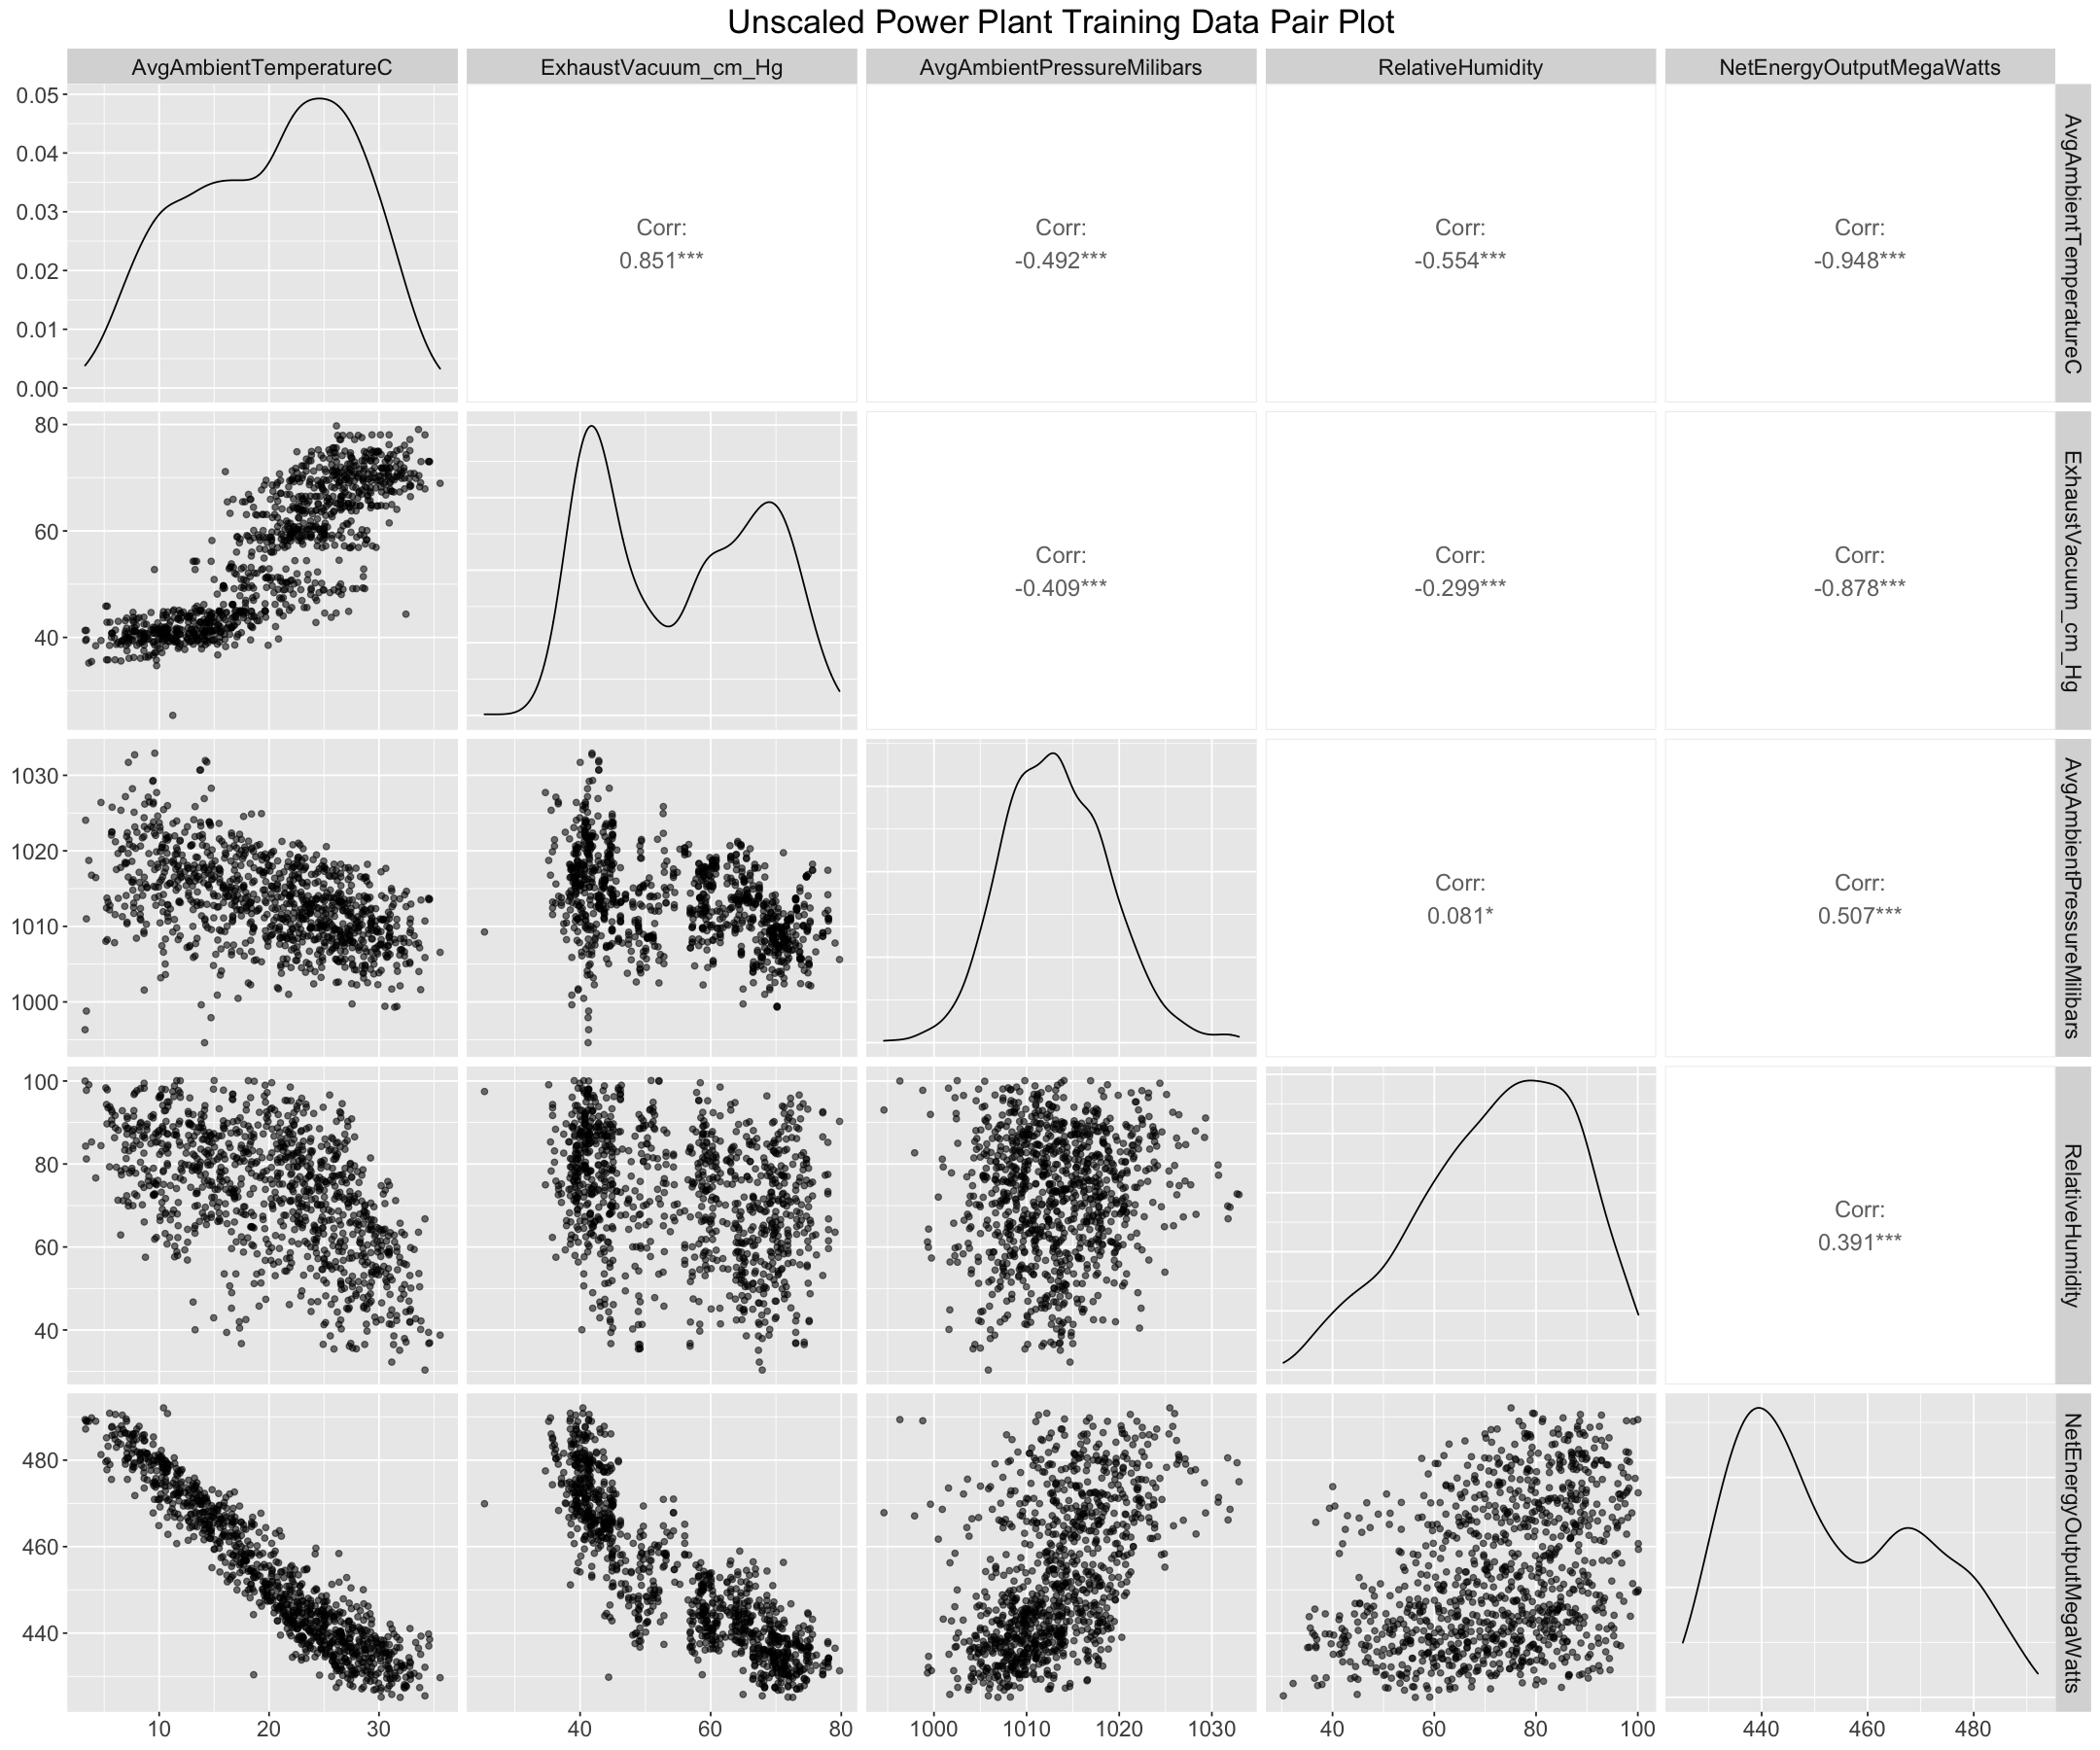

In [6]:
# set plot size options
options(repr.plot.width = 18, repr.plot.height = 15)

# subset the data for plotting (just looks like black blobs otherwise)
power_train_subset <- power_train %>% sample_frac(0.15) 

# pair plot for concrete data
ggpairs(power_train_subset,
            mapping = aes(alpha = 0.2),
            lower=list(combo=wrap("facethist", binwidth=0.5)),
            upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Unscaled Power Plant Training Data Pair Plot") +
        theme(text = element_text(size = 17),
              plot.title = element_text(hjust = 0.5))

#### Calculate Variance Inflation Factors for All Predictors

In the pair plot above, some of the predictors appear highly correlated (e.g. AvgAmbientTemperatureC vs ExhaustVacuum_cm_Hg). Below we calculate the VIF for all predictors to determine if any variables should be removed in order to stabalize parameter estimation. We will keep any variables with VIF < 5 (arbitrary cuttoff from class). 

In [7]:
predictor_names <- colnames(power_train %>% select(-NetEnergyOutputMegaWatts))
vif_all_predictors <- list()
runs <- length(predictor_names)
precision = 4

for (i in 1:runs) {
    curr_pred = predictor_names[1]
    predictor_names = predictor_names[-1] # drop the current pred so we don't calc VIF against itself (divide by zero)
    
    for (other_pred in predictor_names){
        rsq <- cor(power_train[curr_pred], 
                   power_train[other_pred],
                   method='pearson')^2
        
        vif_all_predictors[paste(curr_pred, other_pred , sep = " vs ")] = round(1 / (1 - rsq), precision)
    }
}


Although AmbientTemperatureC vs ExhaustVacuum_cm_Hg are highly correlated, the VIF suggests that it is likely not high enough to be problematic, so we will keep all predictors in model contention at this stage. 

In [8]:
vif_df <- data.frame(Variables=names(vif_all_predictors), VIF=as.double(vif_all_predictors))
vif_df


Variables                                            VIF   
1 AvgAmbientTemperatureC vs ExhaustVacuum_cm_Hg        3.4810
2 AvgAmbientTemperatureC vs AvgAmbientPressureMilibars 1.3486
3 AvgAmbientTemperatureC vs RelativeHumidity           1.4374
4 ExhaustVacuum_cm_Hg vs AvgAmbientPressureMilibars    1.2056
5 ExhaustVacuum_cm_Hg vs RelativeHumidity              1.1132
6 AvgAmbientPressureMilibars vs RelativeHumidity       1.0113

### Try forward selection of parameters? (probably won't do this)

### Cross-validation 

Generate all possible model strings (no including interactions)

TODO: Interactions

In [9]:
power_train_5fold_cv <- vfold_cv(power_train, v = 5)

In [10]:
vars <- colnames(power_test)
N <- list(1,2,3,4)

# use combn to generate all variable combinations
all_combos <- sapply(N, function(v) combn(x=vars[1:4], v))
model_strings <- c()
                     
for(combo_set in all_combos){
    for(j in seq(ncol(combo_set))){
        model_strings <- append(model_strings, paste("NetEnergyOutputMegaWatts", "~", paste(combo_set[,j], collapse="+")))
        
        # don't double add the single term main effect models
        if (length(combo_set[,j]) > 1) {
            model_strings <- append(model_strings, paste("NetEnergyOutputMegaWatts", "~", paste(combo_set[,j], collapse="*")))
        }
    }
}

# add the null model                     
model_strings <- append(model_strings, "NetEnergyOutputMegaWatts ~ 1")

#### The list below is all the models that will be tested in cross-validation workflow

Models that only show the interaction terms also include main effects, but the model string is written in shorthand.

In [11]:
print(model_strings)

 [1] "NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC"                                                                
 [2] "NetEnergyOutputMegaWatts ~ ExhaustVacuum_cm_Hg"                                                                   
 [3] "NetEnergyOutputMegaWatts ~ AvgAmbientPressureMilibars"                                                            
 [4] "NetEnergyOutputMegaWatts ~ RelativeHumidity"                                                                      
 [5] "NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+ExhaustVacuum_cm_Hg"                                            
 [6] "NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC*ExhaustVacuum_cm_Hg"                                            
 [7] "NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+AvgAmbientPressureMilibars"                                     
 [8] "NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC*AvgAmbientPressureMilibars"                                     
 [9] "NetEnergyOutputMegaWatts ~

#### Next we run 5 fold cross-validation for each of the above models, recording the mean RMSE on the validation sets.

In [12]:
cv_results <- tibble(model_string = character(), val_rmse = numeric(), adj_rsq = numeric())

# extract test and train data into separate columns in the fold_cv tibble
power_train_5fold_cv <- power_train_5fold_cv %>% 
  mutate(
    train = map(splits, ~training(.x)), 
    validate = map(splits, ~testing(.x))
  )


for (model_string in model_strings) {
    
    # generate the models for all cross-val splits
    evaluated_models <- power_train_5fold_cv %>%
        mutate(model = map(train, ~lm(formula = as.formula(model_string), data = .x))) %>% 
    
    # map the real response validation set response and predicted response to validate_actual & validate_predicted
        mutate(validate_actual = map(validate, ~.x$NetEnergyOutputMegaWatts),
               validate_predicted = map2(model, validate, ~predict(.x, .y))) %>% 
    
    # calculate the RMSE between the real and predicted on the validation set (simplfied with Metrics library)   
        mutate(validate_rmse = map2_dbl(validate_actual, validate_predicted,
               ~rmse(actual = .x, predicted = .y)))
    
    
    cv_results <- cv_results %>% add_row(model_string = model_string, 
                                         val_rmse = mean(evaluated_models$validate_rmse),
                                         adj_rsq = evaluated_models$model %>% map(., ~(summary(.x))$adj.r.squared) %>% unlist() %>% mean())
   
        
}


print("All models with interaction terms also have the main effects added in, but the model_string is shorthanded to exclude them")
cv_results %>% arrange(val_rmse)


[1] "All models with interaction terms also have the main effects added in, but the model_string is shorthanded to exclude them"


model_string                                                                                                     
1  NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC*ExhaustVacuum_cm_Hg*AvgAmbientPressureMilibars*RelativeHumidity
2  NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC*ExhaustVacuum_cm_Hg*RelativeHumidity                           
3  NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC*ExhaustVacuum_cm_Hg*AvgAmbientPressureMilibars                 
4  NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+ExhaustVacuum_cm_Hg+AvgAmbientPressureMilibars+RelativeHumidity
5  NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+ExhaustVacuum_cm_Hg+RelativeHumidity                           
6  NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC*AvgAmbientPressureMilibars*RelativeHumidity                    
7  NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC*RelativeHumidity                                               
8  NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC*ExhaustVacuum_cm_Hg                                            
9  NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+AvgAmbientPressureMilibars+RelativeHumidity                    
10 NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+RelativeHumidity                                               
11 NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+ExhaustVacuum_cm_Hg+AvgAmbientPressureMilibars                 
12 NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+ExhaustVacuum_cm_Hg                                            
13 NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC+AvgAmbientPressureMilibars                                     
14 NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC*AvgAmbientPressureMilibars                                     
15 NetEnergyOutputMegaWatts ~ AvgAmbientTemperatureC                                                                
16 NetEnergyOutputMegaWatts ~ ExhaustVacuum_cm_Hg*AvgAmbientPressureMilibars*RelativeHumidity                       
17 NetEnergyOutputMegaWatts ~ ExhaustVacuum_cm_Hg+AvgAmbientPressureMilibars+RelativeHumidity                       
18 NetEnergyOutputMegaWatts ~ ExhaustVacuum_cm_Hg*AvgAmbientPressureMilibars                                        
19 NetEnergyOutputMegaWatts ~ ExhaustVacuum_cm_Hg+AvgAmbientPressureMilibars                                        
20 NetEnergyOutputMegaWatts ~ ExhaustVacuum_cm_Hg*RelativeHumidity                                                  
21 NetEnergyOutputMegaWatts ~ ExhaustVacuum_cm_Hg+RelativeHumidity                                                  
22 NetEnergyOutputMegaWatts ~ ExhaustVacuum_cm_Hg                                                                   
23 NetEnergyOutputMegaWatts ~ AvgAmbientPressureMilibars*RelativeHumidity                                           
24 NetEnergyOutputMegaWatts ~ AvgAmbientPressureMilibars+RelativeHumidity                                           
25 NetEnergyOutputMegaWatts ~ AvgAmbientPressureMilibars                                                            
26 NetEnergyOutputMegaWatts ~ RelativeHumidity                                                                      
27 NetEnergyOutputMegaWatts ~ 1                                                                                     
   val_rmse  adj_rsq  
1   4.252300 0.9376846
2   4.337507 0.9350726
3   4.477524 0.9309139
4   4.539478 0.9288965
5   4.548293 0.9286080
6   4.642084 0.9256203
7   4.652311 0.9252913
8   4.660164 0.9250306
9   4.778304 0.9212202
10  4.779221 0.9211936
11  4.874054 0.9180320
12  4.937977 0.9158152
13  5.367306 0.9005822
14  5.367543 0.9005673
15  5.414960 0.8987876
16  7.353529 0.8134968
17  7.507611 0.8055207
18  7.807791 0.7895986
19  7.837476 0.7880090
20  8.027155 0.7775308
21  8.098942 0.7735822
22  8.382168 0.7574510
23 13.313389 0.3882294
24 13.316066 0.3879397
25 14.548903 0.2689029
26 15.612984 0.1583468
27 17.017159 0.0000000

In [13]:
top_10_model_strings <- cv_results %>% 
        arrange(val_rmse)%>% 
        head(10) %>% 
        select(model_string)

models = list()

idx = 1
for (mod in top_10_model_strings$model_string) {
    models[[idx]] = lm(as.formula(mod), data=power_train)
    idx = idx + 1
}


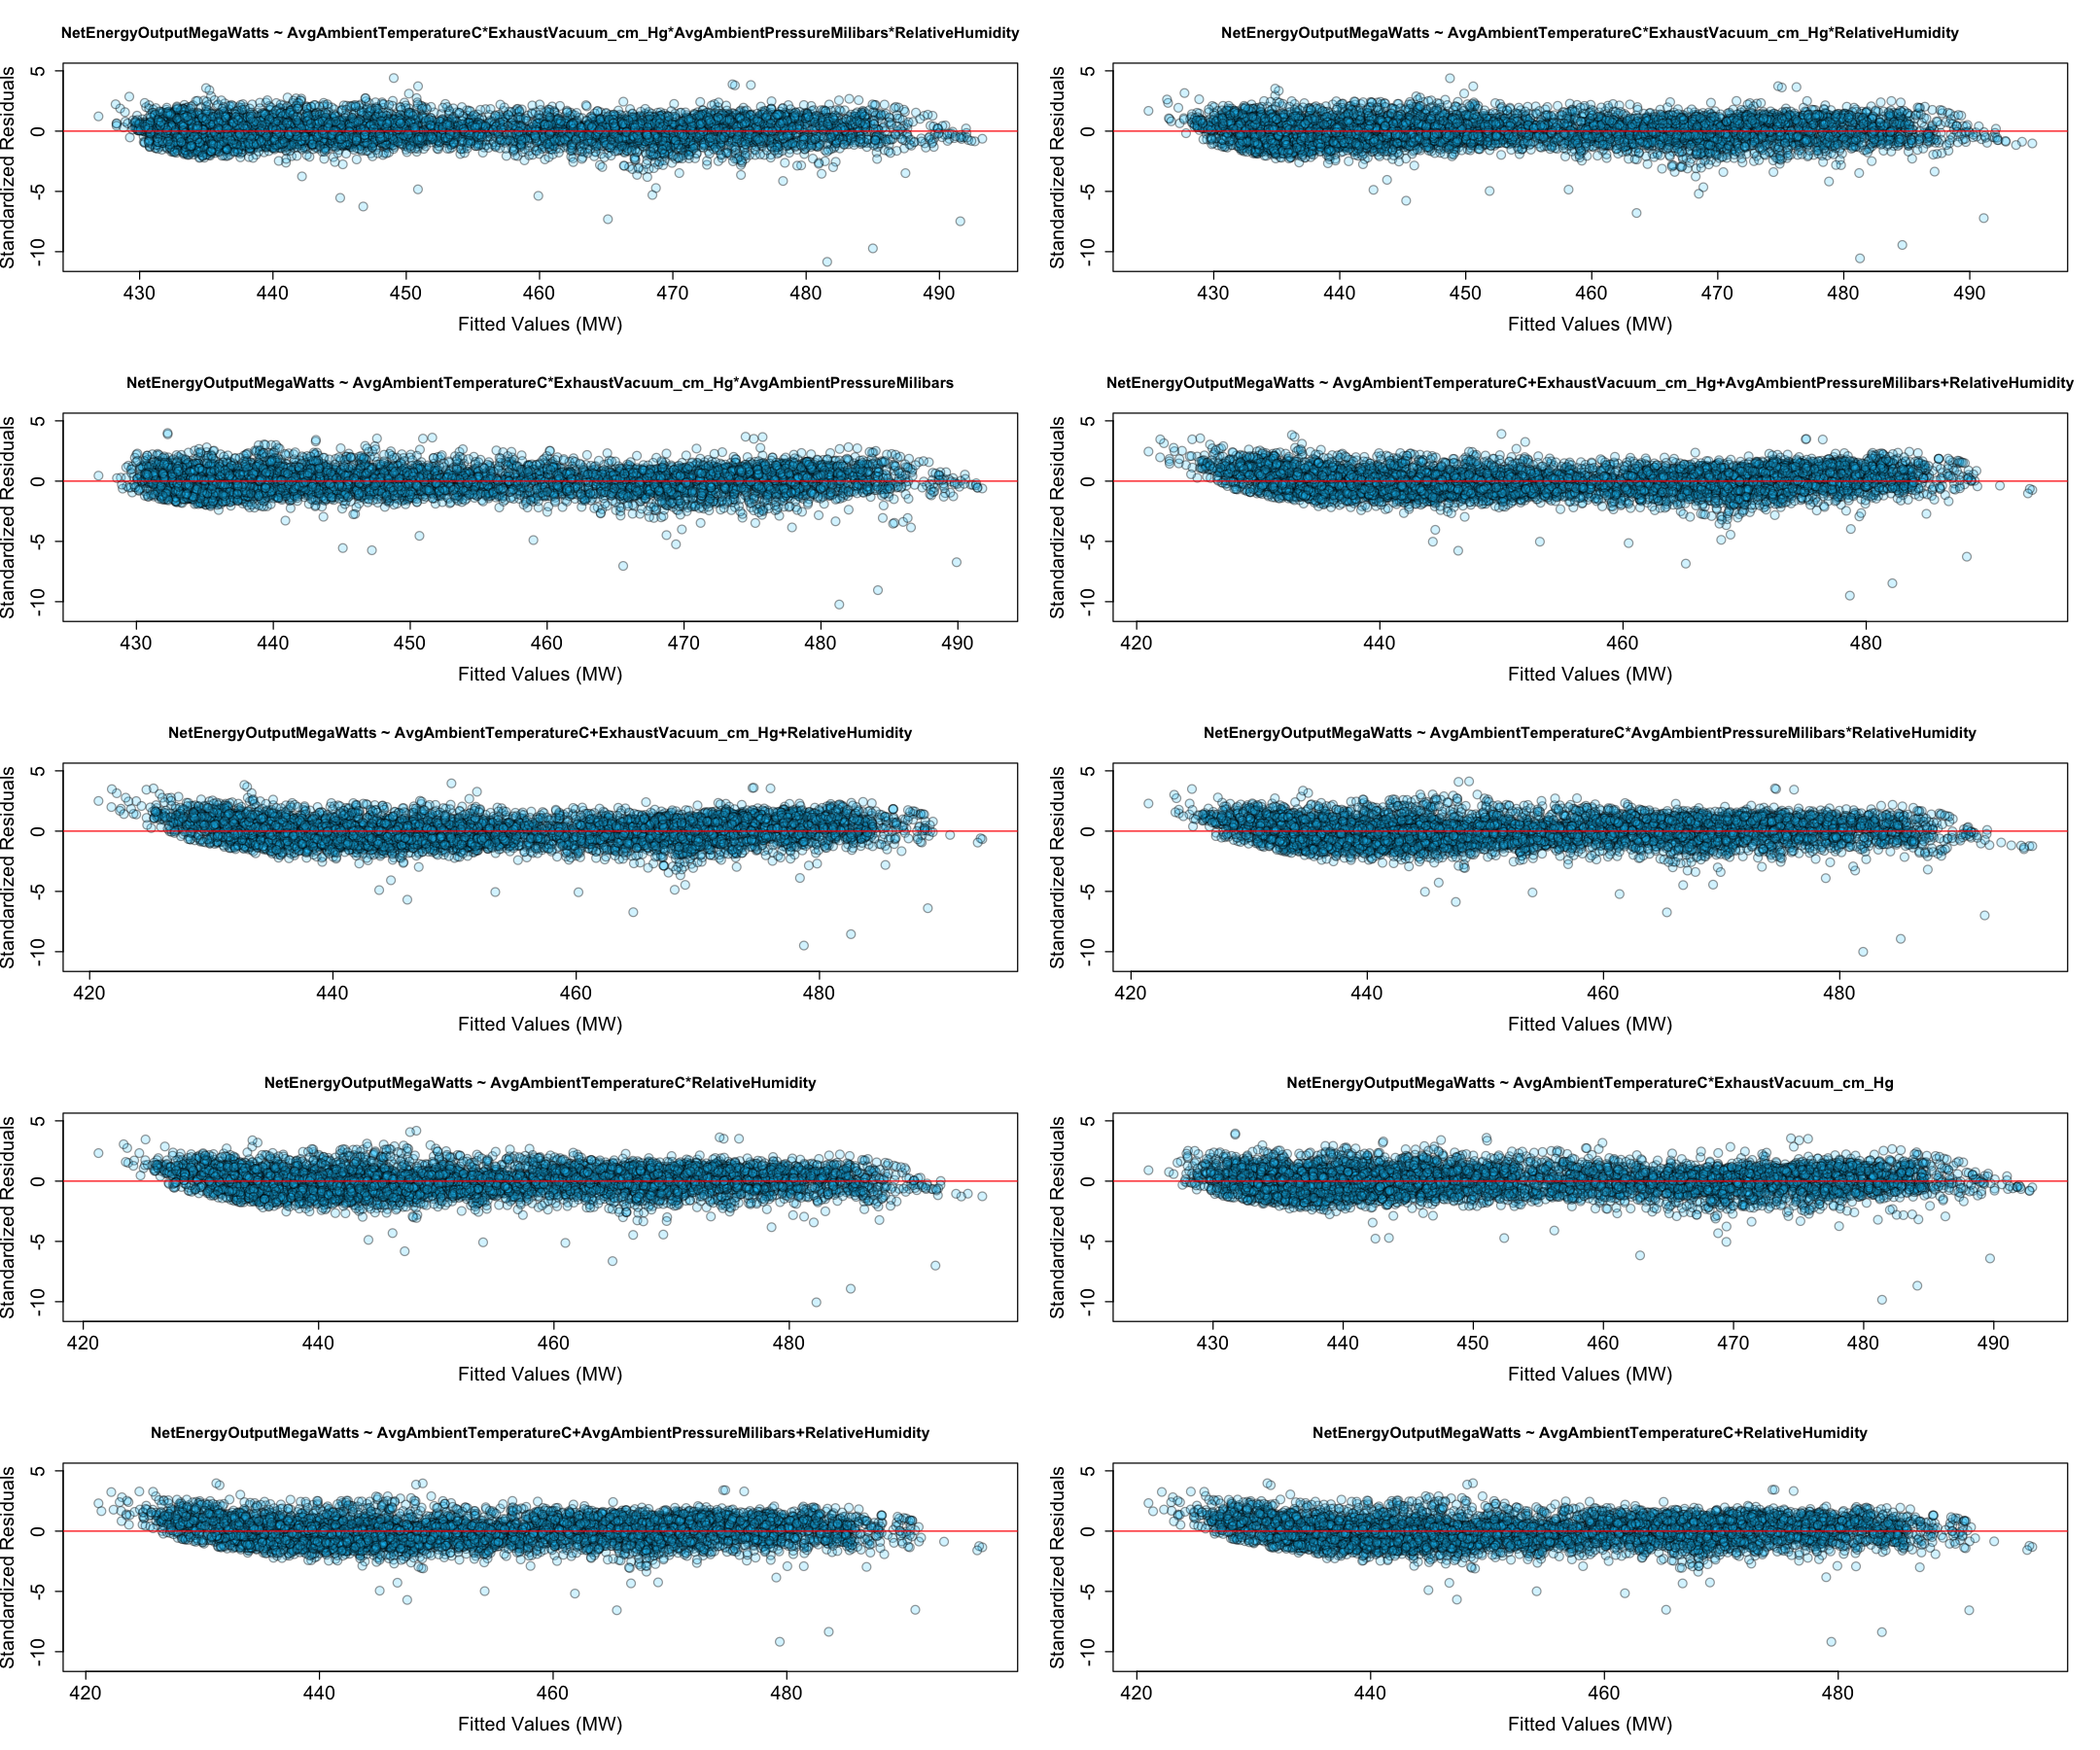

In [14]:
par(mfrow=c(5,2))

name_idx = 1
for (model in models) {
    plot(model$fitted.values, rstandard(model),
         pch=21, 
         bg=rgb(red = 0, green = 0.8, blue = 1, alpha = 0.2), 
         col=rgb(red = 0, green = 0, blue = 0, alpha = 0.4), 
         cex=1.5,
         cex.sub = 1.5,  # Subtitle size
         cex.lab = 1.5,    # X-axis and Y-axis labels size
         cex.axis = 1.5,
         xlab="Fitted Values (MW)",
         ylab="Standardized Residuals",
         ylim=c(-11,5),
         main=top_10_model_strings$model_string[name_idx]) 
    abline(h=0, col="red")
    name_idx = name_idx + 1
    
}
# summary(models[[1]])

The standardized residual plots above show that while each of these models have similar adjusted $R^2$ and RMSE, most models have some systematic bias to underestimate low power output (as evidenced by the upward tail on the LHS of these plots for many models). The only models which remove this are the models which contain interaction terms between exhuast vacuum pressure and average ambient temperature (models at the top of the plot). 

In [15]:
# Chosen manually based on the top 10 models and their residual plots
best_model <- lm(NetEnergyOutputMegaWatts ~ . + AvgAmbientTemperatureC*ExhaustVacuum_cm_Hg*AvgAmbientPressureMilibars*RelativeHumidity, data=power_train)

test_prediction <- predict(best_model, power_test)
test_pred_interval <- predict(best_model, power_test, interval = 'prediction')

results <- data.frame(pred=test_prediction, actual=power_test$NetEnergyOutputMegaWatts)
test_rmse <- round(rmse(results$actual, results$pred), precision)

print(paste("The RMSE for the test data is:", 
            test_rmse, 
            ", compared to", 
            (cv_results %>% arrange(val_rmse))$val_rmse[1] %>% round(precision), 
            "in cross-validation."))

[1] "The RMSE for the test data is: 4.3143 , compared to 4.2523 in cross-validation."


In [16]:
mean(test_pred_interval[,'lwr'])

[1] 446.1089

In [17]:
summary(best_model)$coefficients

Estimate     
(Intercept)                                                                             4.318106e+03
AvgAmbientTemperatureC                                                                 -2.055893e+02
ExhaustVacuum_cm_Hg                                                                    -8.450710e+01
AvgAmbientPressureMilibars                                                             -3.744898e+00
RelativeHumidity                                                                       -2.533337e+01
AvgAmbientTemperatureC:ExhaustVacuum_cm_Hg                                              3.831101e+00
AvgAmbientTemperatureC:AvgAmbientPressureMilibars                                       2.009862e-01
ExhaustVacuum_cm_Hg:AvgAmbientPressureMilibars                                          8.275193e-02
AvgAmbientTemperatureC:RelativeHumidity                                                 1.782479e+00
ExhaustVacuum_cm_Hg:RelativeHumidity                                                    5.303901e-01
AvgAmbientPressureMilibars:RelativeHumidity                                             2.502893e-02
AvgAmbientTemperatureC:ExhaustVacuum_cm_Hg:AvgAmbientPressureMilibars                  -3.769729e-03
AvgAmbientTemperatureC:ExhaustVacuum_cm_Hg:RelativeHumidity                            -3.070894e-02
AvgAmbientTemperatureC:AvgAmbientPressureMilibars:RelativeHumidity                     -1.771729e-03
ExhaustVacuum_cm_Hg:AvgAmbientPressureMilibars:RelativeHumidity                        -5.237237e-04
AvgAmbientTemperatureC:ExhaustVacuum_cm_Hg:AvgAmbientPressureMilibars:RelativeHumidity  3.041164e-05
                                                                                       Std. Error  
(Intercept)                                                                            9.648068e+02
AvgAmbientTemperatureC                                                                 3.938971e+01
ExhaustVacuum_cm_Hg                                                                    2.178940e+01
AvgAmbientPressureMilibars                                                             9.524628e-01
RelativeHumidity                                                                       1.239626e+01
AvgAmbientTemperatureC:ExhaustVacuum_cm_Hg                                             7.806775e-01
AvgAmbientTemperatureC:AvgAmbientPressureMilibars                                      3.891050e-02
ExhaustVacuum_cm_Hg:AvgAmbientPressureMilibars                                         2.152220e-02
AvgAmbientTemperatureC:RelativeHumidity                                                5.215546e-01
ExhaustVacuum_cm_Hg:RelativeHumidity                                                   2.827966e-01
AvgAmbientPressureMilibars:RelativeHumidity                                            1.224026e-02
AvgAmbientTemperatureC:ExhaustVacuum_cm_Hg:AvgAmbientPressureMilibars                  7.712845e-04
AvgAmbientTemperatureC:ExhaustVacuum_cm_Hg:RelativeHumidity                            1.043899e-02
AvgAmbientTemperatureC:AvgAmbientPressureMilibars:RelativeHumidity                     5.153060e-04
ExhaustVacuum_cm_Hg:AvgAmbientPressureMilibars:RelativeHumidity                        2.793713e-04
AvgAmbientTemperatureC:ExhaustVacuum_cm_Hg:AvgAmbientPressureMilibars:RelativeHumidity 1.031523e-05
                                                                                       t value  
(Intercept)                                                                             4.475617
AvgAmbientTemperatureC                                                                 -5.219366
ExhaustVacuum_cm_Hg                                                                    -3.878358
AvgAmbientPressureMilibars                                                             -3.931805
RelativeHumidity                                                                       -2.043631
AvgAmbientTemperatureC:ExhaustVacuum_cm_Hg                                              

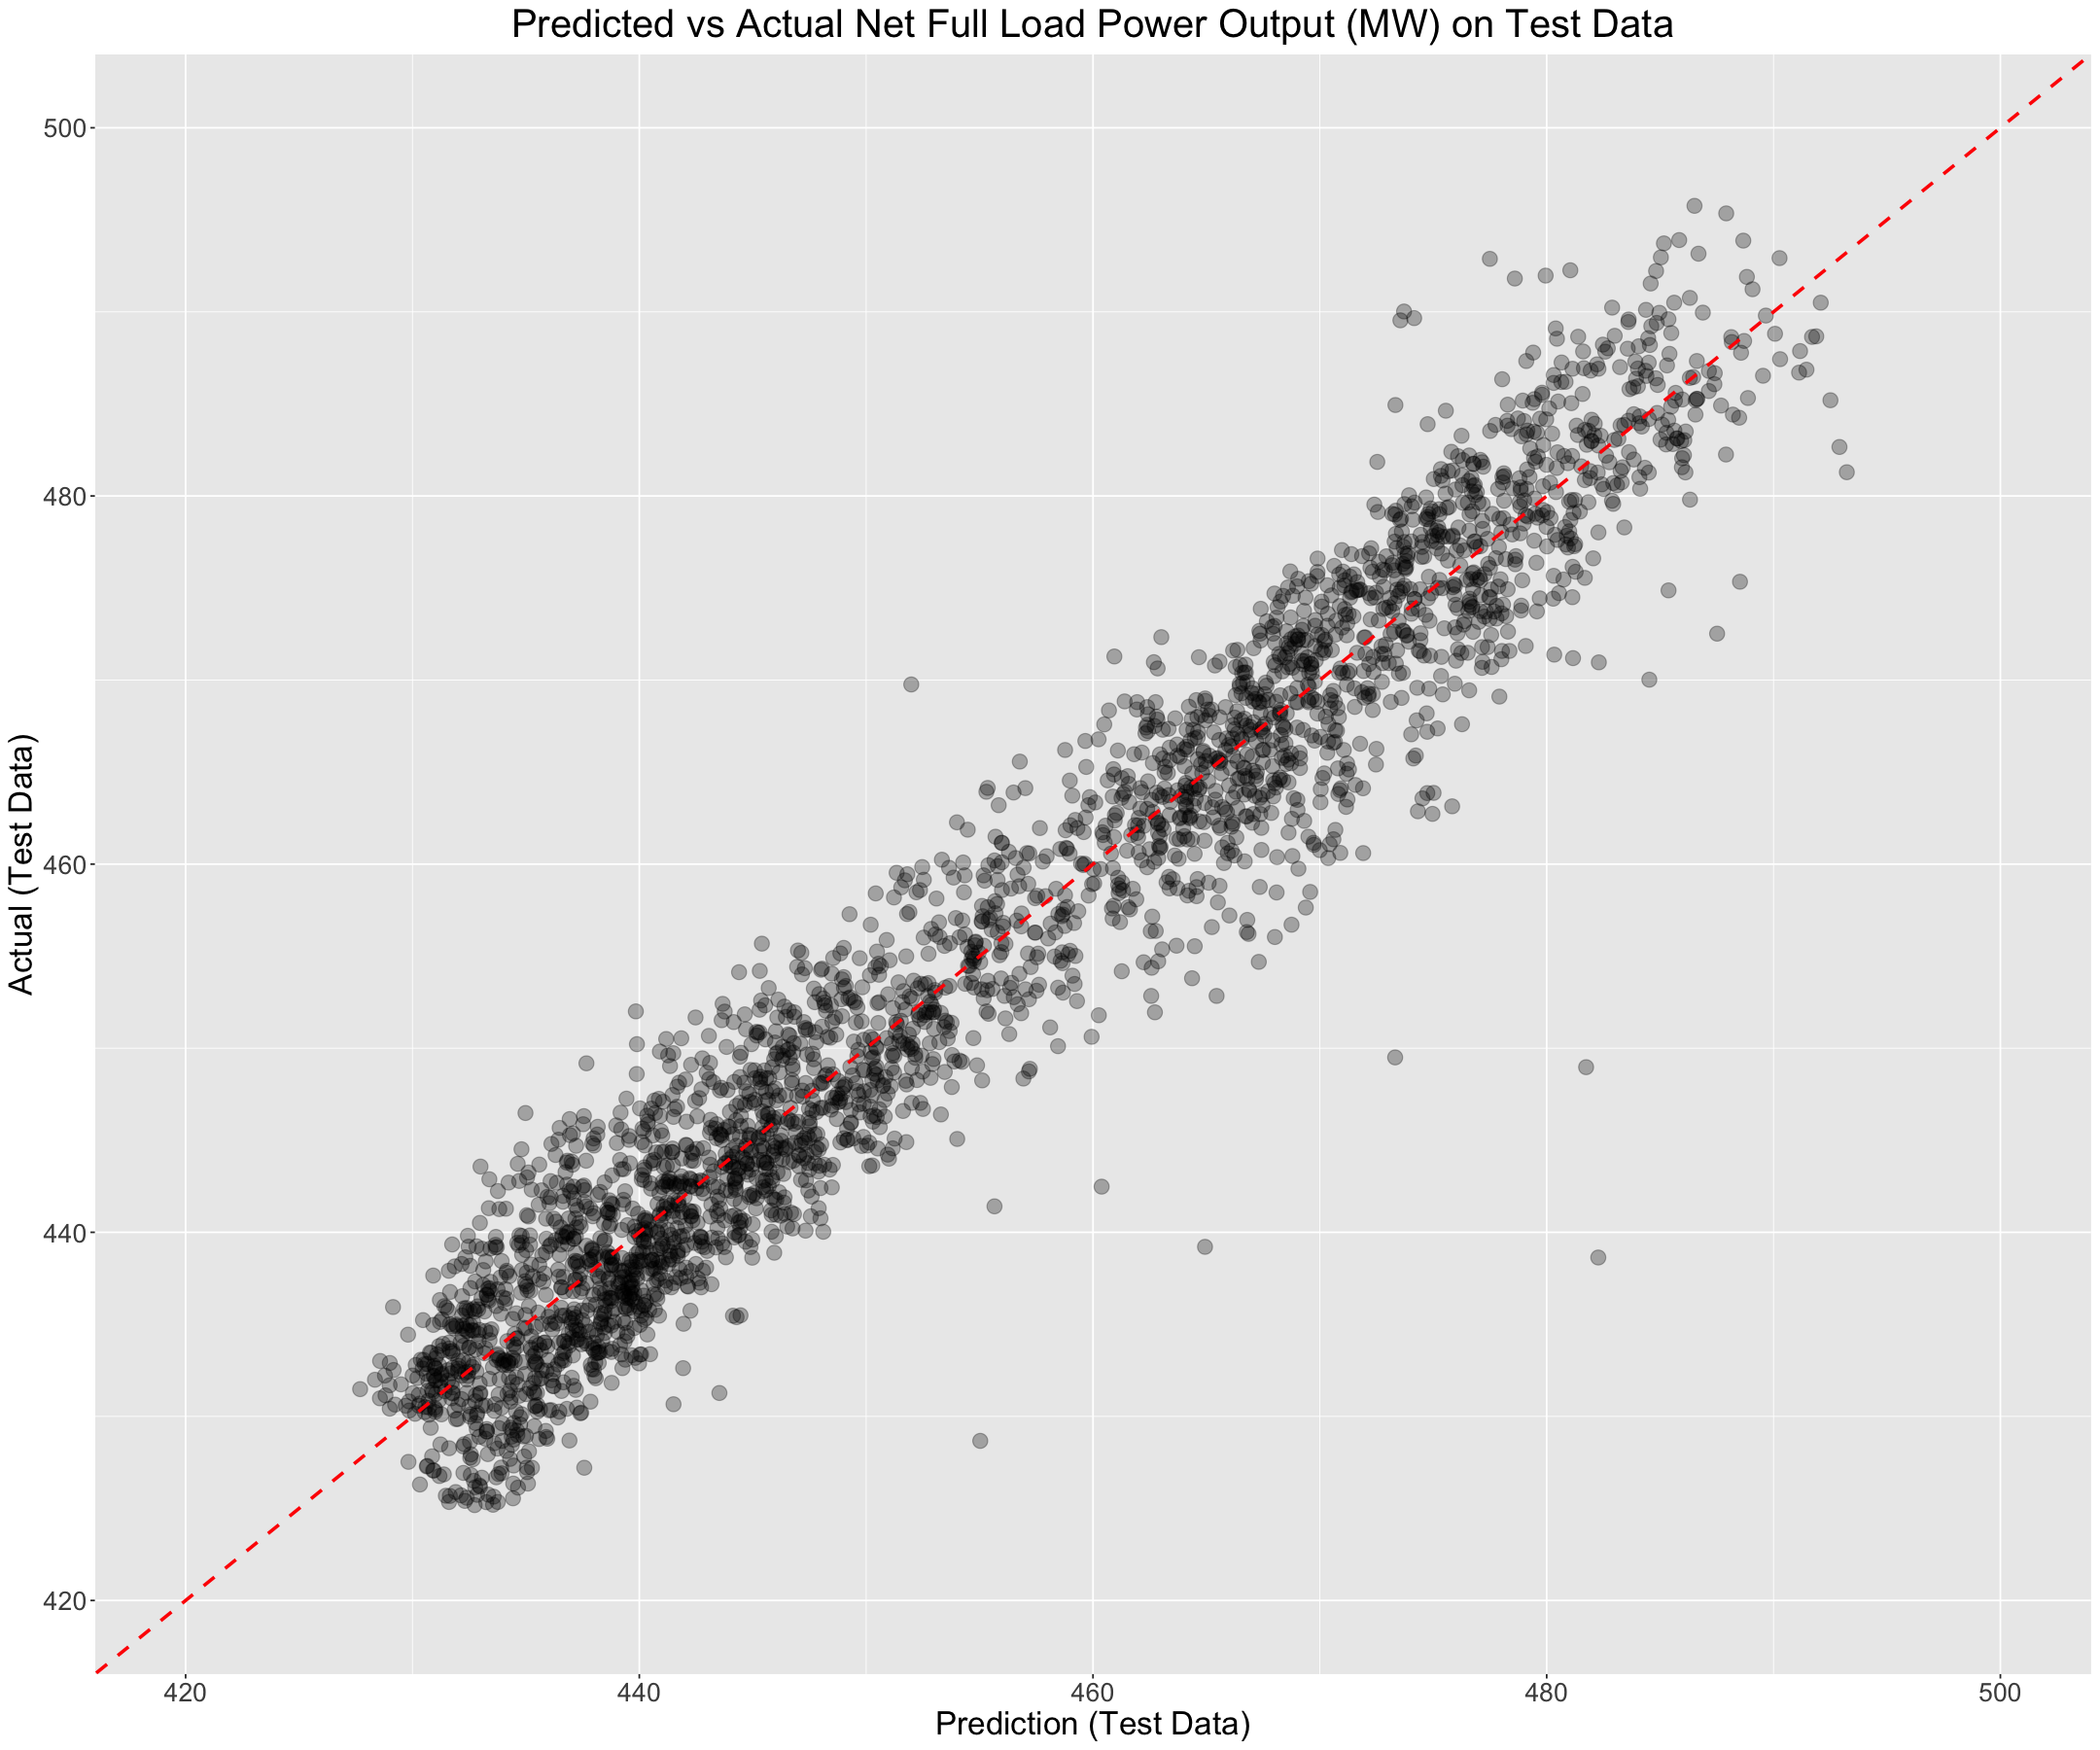

In [18]:
prediction_plot <- results %>% ggplot(aes(x=pred, y=actual)) +
                        geom_point(size=4, alpha=0.3) + 
                        labs(x = "Prediction (Test Data)", y = "Actual (Test Data)") + 
                        ggtitle("Predicted vs Actual Net Full Load Power Output (MW) on Test Data") +
                                theme(text = element_text(size=20),
                                      plot.title = element_text(hjust = 0.5)) +
                        geom_abline(slope=1, intercept=0, col='red', linetype='dashed', size=1) +
                        xlim(420, 500) + ylim(420, 500)
prediction_plot

### Thoughts on prediction goal

We want to predict power output, so ideally we want to choose a model which contains significant terms, and which also does not needlessly include additional terms at little benefit to model performance. I can try a $C_p$ matrix for each model similar to Activity 15 as another way to select a model. Ideally we have as few terms as possible so that when predicting power output we can collect as little data as possible and still have a good result.

From experimentataion it seems like the best trade off model for few predictors is a simple interaction model between ambient temperature and exhuast vacuum pressure. This is probably because a majority of the power generated is going towards heating, additionally the exhuast vacuum pressure is directly related to the power generation of the gas turbine.

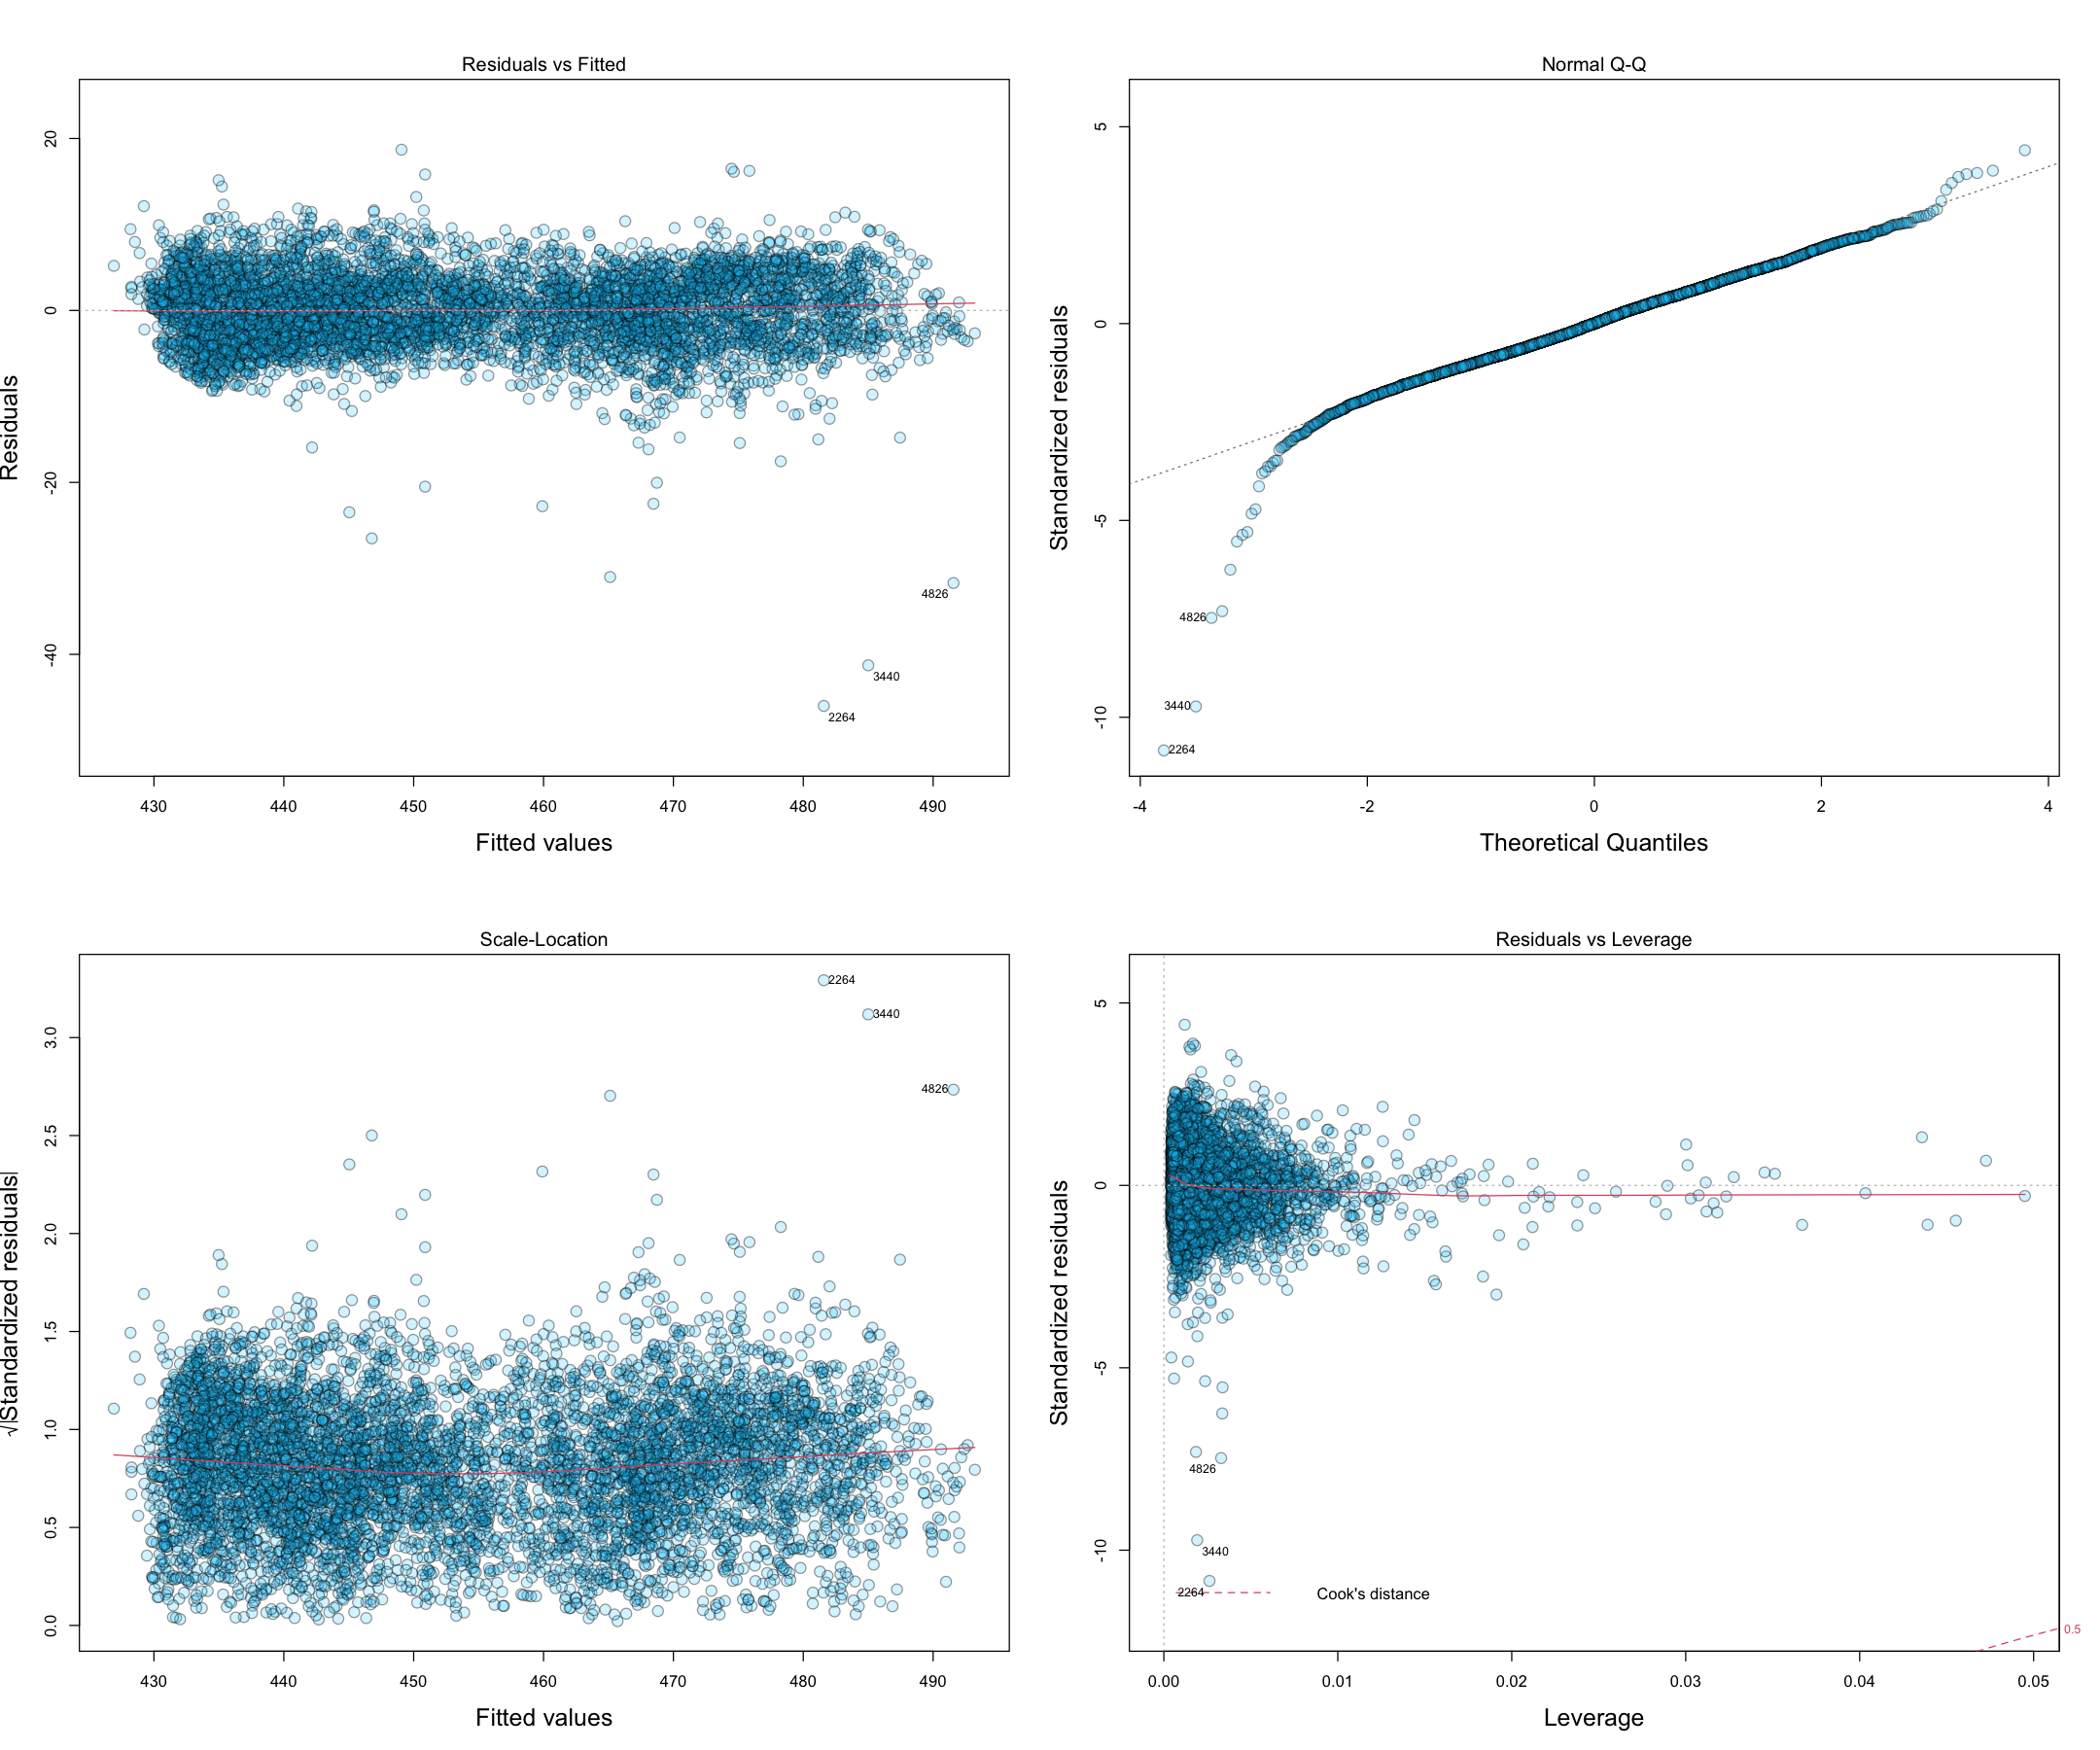

In [19]:
par(mfrow=c(2,2))
plot(best_model, 
     pch=21, 
     bg=rgb(red = 0, green = 0.8, blue = 1, alpha = 0.2), 
     col=rgb(red = 0, green = 0, blue = 0, alpha = 0.4), 
     cex=1.5,
     cex.sub = 1.5,  # Subtitle size
     cex.lab = 1.5,    # X-axis and Y-axis labels size
     cex.axis = 1) # Axis labels size)
